# Lab 4.2 – Brain cancer segmentaion: UNet (MONAI)

This notebook aims to segment brain cancer. **BraTS2020 Dataset** (https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation/data) and **UNet** from MONAI library (https://monai-dev.readthedocs.io/en/fixes-sphinx/_modules/monai/networks/nets/unet.html#UNet) are employed for the trial.

This lab will use 2D UNet, which operates on 2D input and can be sliced ​​from a 3D volume, unlike Lab 4.1. After editing sliding window inferer as described in this tutorial, it can handle the entire flow as shown:
![image](https://github.com/Project-MONAI/tutorials/blob/main/figures/2d_inference_3d_input.png)

This example code will consist of:

0. **Setup**
1. **Load Data & Set Transforms**
2. **Define Model & Set Hyper Parameter**
3. **Train Model**
4. **Inference  & Evaluate**


## 0) Setup
The code below download dataset, imports all required libraries and defines utility functions that will be used in the rest of this notebook.

In [ ]:
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/BraTS20.zip
!unzip -q -o 'BraTS20.zip'

--2025-12-25 11:27:24--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/BraTS20.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/BraTS20.zip [following]
--2025-12-25 11:27:25--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/BraTS20.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41227923 (39M) [application/zip]
Saving to: ‘BraTS20.zip’

BraTS20.zip         100%[===================>]  39.32M  48.7MB/s    in 0.8s    

2025-12-25 11:27:26 (48.7 MB/s) - ‘BraTS20.zip’ saved [

In [ ]:
!pip install monai
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 9.4 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt

import monai
from monai.data import Dataset, CacheDataset, DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference, SliceInferer
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandFlipd,
    Resized,
    ScaleIntensityRanged,
    SqueezeDimd,
)
from monai.utils import first, set_determinism
import numpy as np
from tqdm import tqdm
import glob
import torch
import warnings
warnings.filterwarnings('ignore')

##1) Load Data & Set Transforms

In [ ]:
# Dataset
train_images = sorted(glob.glob(os.path.join("/content/BraTS20/Inputs", "*.nii")))
train_labels = sorted(glob.glob(os.path.join("/content/BraTS20/Outputs", "*.nii")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files, test_files = data_dicts[:12], data_dicts[12:16], data_dicts[16:]

image shape: torch.Size([240, 240, 155]), label shape: torch.Size([240, 240, 155])


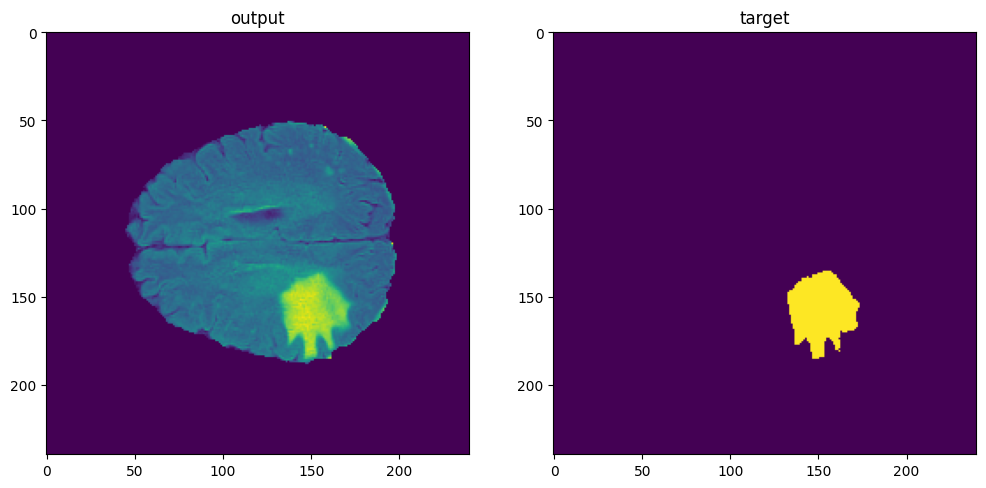

In [ ]:
# Example
class ConvertToTumorChannel(MapTransform):
        def __call__(self, data):
            d = dict(data)
            for key in self.keys:
                d[key] = torch.isin(d[key], torch.tensor([1, 2, 3, 4], device=d[key].device)).float()
            return d

test_all_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ConvertToTumorChannel(keys="label"),
    ]
)

check_all_ds = Dataset(data=test_files, transform=test_all_transforms)
check_all_loader = DataLoader(check_all_ds, batch_size=1)

check_data = first(check_all_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("output")
plt.imshow(image[:, :, 100])
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(label[:, :, 100])
plt.show()

In [ ]:
# Transforms (pre&post proceeding)
roi_size = (128, 128, 128)

train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=True,dtype=torch.float),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1023, b_min=0.0, b_max=1.0, clip=True),
            ConvertToTumorChannel(keys="label"),
            Resized(keys=["image", "label"], spatial_size=roi_size, mode=["bilinear", "nearest-exact"]),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        ]
    )
val_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=True,dtype=torch.float),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1023, b_min=0.0, b_max=1.0, clip=True),
            ConvertToTumorChannel(keys="label"),
            Resized(keys=["image", "label"], spatial_size=roi_size, mode=["bilinear", "nearest-exact"]),
        ]
    )

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

In [ ]:
# DataLoader 3D -> 2D
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)

patch_func = monai.data.PatchIterd(keys=["image", "label"], patch_size=(None, None, 1), start_pos=(0, 0, 0))
patch_transform = Compose([
            SqueezeDimd(keys=["image", "label"], dim=-1),  # squeeze the last dim
            Resized(keys=["image", "label"], spatial_size=[128, 128]),
    ])

train_patch_ds = monai.data.GridPatchDataset(data=train_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)
train_shuffle_ds = monai.data.ShuffleBuffer(train_patch_ds, buffer_size=30, seed=0)
train_loader = DataLoader(train_shuffle_ds, batch_size=4, num_workers=4, pin_memory=torch.cuda.is_available())

val_patch_ds = monai.data.GridPatchDataset(data=val_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)
val_shuffle_ds = monai.data.ShuffleBuffer(val_patch_ds, buffer_size=30, seed=0)
val_loader = DataLoader(val_shuffle_ds, batch_size=4, num_workers=4, pin_memory=torch.cuda.is_available())

Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


## 2) Define Model & Set Hyper Parameter

In [ ]:
device = torch.device("cuda")
model = UNet(spatial_dims=2, in_channels=1, out_channels=2,
             channels=(16, 32, 64, 128), strides=(2, 2, 2), num_res_units=2, norm=Norm.BATCH).to(device)

learning_rate = 0.0001 # @param {type:"slider", min:1e-4, max:1e-3, step:1e-4}
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
dice_metric = DiceMetric(include_background=False, reduction="mean")

max_epochs = 20  # @param {type:"slider", min:5, max:50, step:1}
val_interval = 2 # @param {type:"slider", min:1, max:10, step:1}

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for i, batch_data in enumerate(train_loader):
        step += 1
        inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if step % 20 == 0:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (val_data["image"].to(device), val_data["label"].to(device))

                roi_size = (128, 128)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("UNet2D_best_metric_model.pth"))
                print("saved new best metric model")
            print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
    if (epoch + 1) % 20 == 0:
            torch.save(model.state_dict(), os.path.join(f"UNet2D_{epoch + 1}_metric_model.pth"), _use_new_zipfile_serialization=False)
            np.save(os.path.join("UNet2D_epoch_loss"), np.array(epoch_loss_values))                                                      #####
            np.save(os.path.join("UNet2D_metric_values"), np.array(metric_values))

----------
epoch 1/20
20/3, train_loss: 1.3634
40/3, train_loss: 1.3058
60/3, train_loss: 1.2541
80/3, train_loss: 1.2165
epoch 1 average loss: 1.3013
----------
epoch 2/20
20/3, train_loss: 1.1042
40/3, train_loss: 1.1403
60/3, train_loss: 1.1183
80/3, train_loss: 1.0808
epoch 2 average loss: 1.1198
saved new best metric model
current epoch: 2 current mean dice: 0.1733
best mean dice: 0.1733 at epoch: 2
----------
epoch 3/20
20/3, train_loss: 1.0107
40/3, train_loss: 1.0507
60/3, train_loss: 1.0414
80/3, train_loss: 1.0058
epoch 3 average loss: 1.0347
----------
epoch 4/20
20/3, train_loss: 0.9487
40/3, train_loss: 0.9846
60/3, train_loss: 0.9786
80/3, train_loss: 0.9494
epoch 4 average loss: 0.9717
saved new best metric model
current epoch: 4 current mean dice: 0.3244
best mean dice: 0.3244 at epoch: 4
----------
epoch 5/20
20/3, train_loss: 0.8965
40/3, train_loss: 0.9300
60/3, train_loss: 0.9279
80/3, train_loss: 0.9008
epoch 5 average loss: 0.9194
----------
epoch 6/20
20/3, train

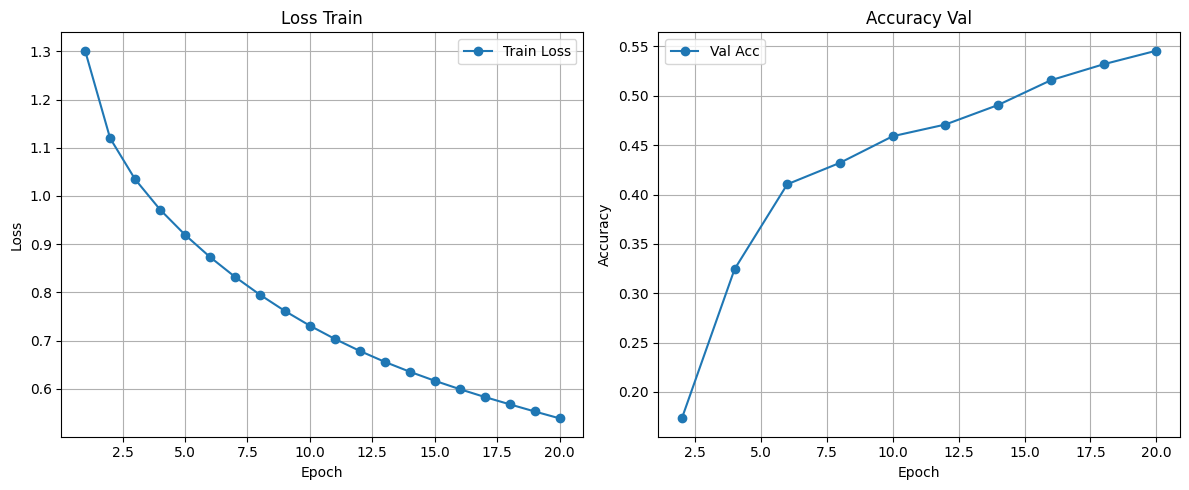

In [ ]:
# Plot grape
n_loss = range(1, len(epoch_loss_values) + 1)
n_acc = range(val_interval, val_interval * len(metric_values) + 1, val_interval)
plt.figure(figsize=(12, 5))

# 🔹 Loss
plt.subplot(1, 2, 1)
plt.plot(n_loss, epoch_loss_values, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Train')
plt.legend()
plt.grid(True)

# 🔹 Accuracy
plt.subplot(1, 2, 2)
plt.plot(n_acc, metric_values, marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Val')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4) Inference  & Evaluate

In [ ]:
roi_size_test = (128, 128, 128)
test_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"],ensure_channel_first=True,image_only=True,dtype=torch.float),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1023, b_min=0.0, b_max=1.0, clip=True),
        ConvertToTumorChannel(keys="label"),
        Resized(keys=["image", "label"], spatial_size=roi_size_test, mode=["bilinear", "nearest-exact"]),
    ]
)

test_org_ds = Dataset(data=test_files, transform=test_org_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=0)

100%|██████████| 128/128 [00:00<00:00, 375.83it/s]


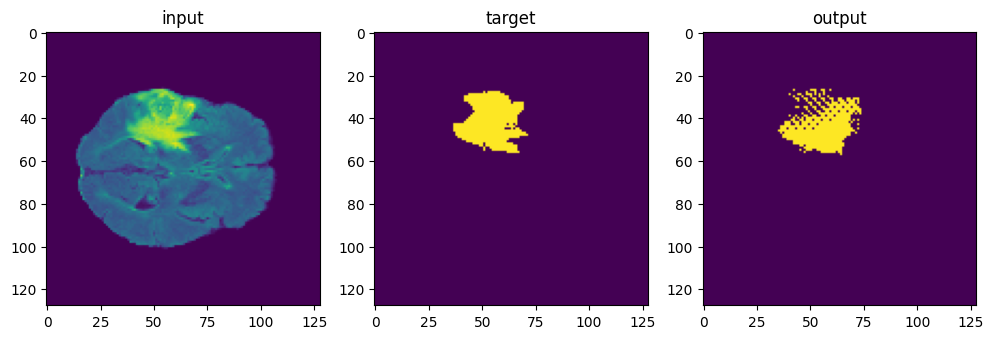

100%|██████████| 128/128 [00:00<00:00, 329.45it/s]


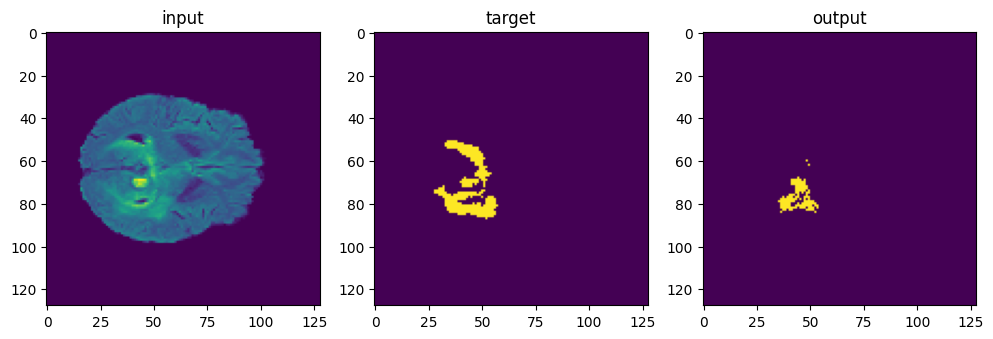

100%|██████████| 128/128 [00:00<00:00, 267.72it/s]


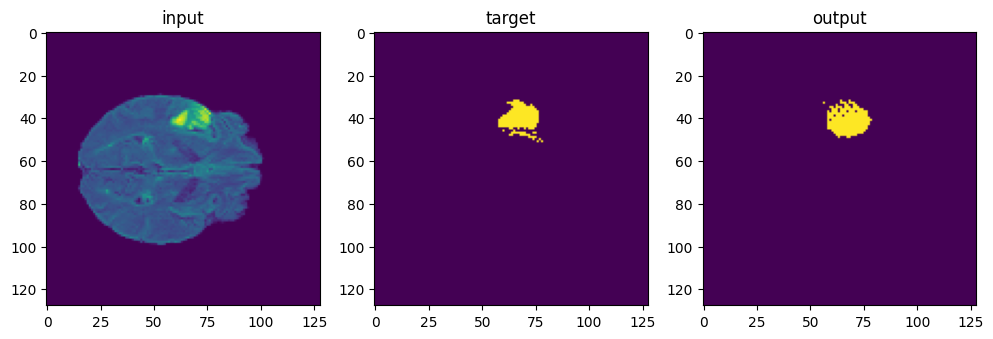

100%|██████████| 128/128 [00:00<00:00, 352.24it/s]


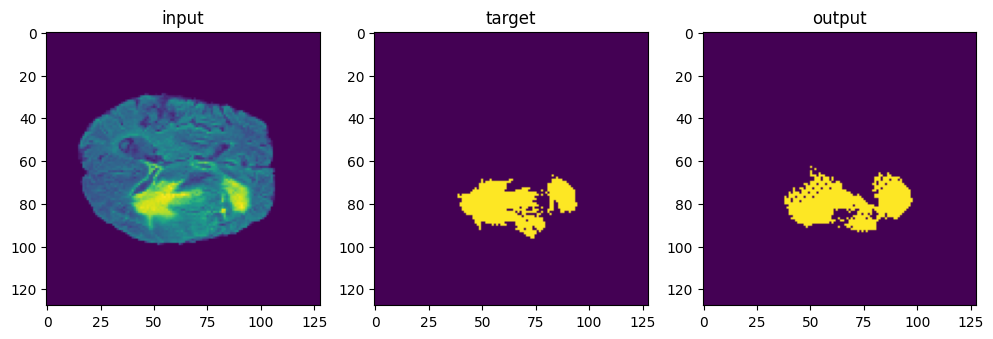


Mean Dice: 0.7047


In [ ]:
model.load_state_dict(torch.load(os.path.join("UNet2D_best_metric_model.pth")))                                                          #####
model.eval()
DSC_all= []
with torch.no_grad():

    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        sw_batch_size = 1
        axial_inferer = SliceInferer(roi_size=(128, 128), spatial_dim=2, sw_batch_size=1, cval=-1, progress=True)

        output = axial_inferer(test_inputs, model)

        pred = torch.argmax(output, dim=1, keepdim=True)
        dice_metric = DiceMetric(include_background=False, reduction="mean")

        dice_metric(y_pred=pred, y=test_data["label"].to(device))
        DSC_all.append(dice_metric.aggregate().item())
        dice_metric.reset()

        plt.figure("check", (12, 6))
        plt.subplot(1, 3, 1)
        plt.title("input")
        plt.imshow(test_data["image"][0][0][:, :, 60])
        plt.subplot(1, 3, 2)
        plt.title("target")
        plt.imshow(test_data["label"][0][0][:, :, 60])
        plt.subplot(1, 3, 3)
        plt.title("output")
        plt.imshow(pred[0][0][:, :, 60].detach().cpu().numpy())
        plt.show()

print(f"\nMean Dice: {np.mean(DSC_all):.4f}")